### Group 16 - Yousef Kanj, Elias Antoun, Zhansaya Jumasheva, Ahmad Saad
# Traffic sign classification, Adverserial attacks, and Defence

With self driving cars becoming a popular topic in today's world, alot of problems are required to be solved in order to make the idea a safe and reliable technology. One important task is to be able to see and classify traffic signs correctly for the safety of the passengers and pedestrians. Such a task can be classified as a computer vision task and traffic sign recognition can be solved very reliably using Convolutional Neural Networks.

 A malicious attack on our self driving car may target the data between the sensor and the network, and add small perturbations to the incoming data so that the CNN predicts it incorrectly. Such an attack, part of what we call Adverserial Attacks, is called the Fast Gradient Sign Method (FGSM). Essentially it takes the input data, and adds to it a very small coefficent multiplied by the sign of its gradient of the loss fucntion, so that the original image looks unchanged. This would cause our model to return a wrong prediction.

 It is important for us to study how can we defend against these Adverserial Attacks, since this has real life applications for our safety. The dataset we will be using is the German Traffic Sign Recognition Benchmark (GTSRB) dataset. It has 62000 images of traffic signs classified into 43 classes.

 We will first train a CNN to recognize our dataset, we will then apply FGSM to our input images as part of our Adverserial Attack, and then we will try to defend against the FGSM method and see how well we did.




1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


2. Define Functions for Loading and Preprocessing Data

In [2]:
# This function loads each image from its path and makes sure it is resized to it's correct size
def load_and_preprocess_image(image_path, img_size=(32, 32)):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # Here we normalize the pixels to [0,1]
        img = tf.image.resize(img, img_size)
        return img
    # A few images returned errors during reading which is why we added a Try Except statement.
    except tf.errors.NotFoundError:
        raise ValueError(f"Image not found or unable to load: {image_path}")

# This function loads the .csv files which contains the labels to each image path, so that we can associate each label to a loaded image
def load_dataset(dataset_path, csv_file, img_size=(32, 32)):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row['Path'])
        images.append(load_and_preprocess_image(image_path, img_size))
        labels.append(row['ClassId'])
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

3. Load and Split the Dataset

In [3]:
TRAIN_PATH = r"C:\Users\youse\Desktop\FDS final"
TEST_PATH = r"C:\Users\youse\Desktop\FDS final"
TRAIN_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"
TEST_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"

train_images, train_labels = load_dataset(TRAIN_PATH, TRAIN_CSV)
test_images, test_labels = load_dataset(TEST_PATH, TEST_CSV)

# Split the training data into a training set and a validation set 
train_images, val_images, train_labels, val_labels = train_test_split(train_images.numpy(), train_labels.numpy(), test_size=0.2, random_state=42)

4. Build the CNN Model

Our CNN has an input layer that takes a 32x32 image with 3 color channels.  It then goes through the first convolutional layer of 32 3x3 filter kernels. These kenrels use Rectified Linear Units for activation. The activation functions are essential and are what allow our neural network to work as a non-linear classifier. In our case our activation function is ReLU rakes the max{0,x}. It then goes to a Maxpooling layer which places a 2x2 kernel over the feature map and reduces its dimensions by taking the max value in that 2x2 window.

This feature map is then passed through convoluting layer twice more, with another maxpooling layer in between them. These convolutions serve to recognize more complex features from our input. Finally the feature map is flattened into a 1D array, fed to a dense layer connected 1 to 1 to our flattened array. This dense layer is then connected to another dense 43 neurons, each corresponding to one of the unique classes we have.

We use the Adaptive Moment Estimation (ADAM) optimizer instead of stochastic gradient descent.  

In [24]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


5. Train the Model
You can notice that we used a train-validate-test split for our data, the validation split is used at each epoch for the model to try and predict. It is not part of the training set and no direct learning comes as a result of it. It helps tune the model hyper parameters for the next epoch and ensures that our model isn't overfitting. For example, if our model accuracy is high, but our validation accuracy is low, this is a good indicator of overfitting.

Epoch 1/10
316/316 [==============================] - 3s 8ms/step - loss: 2.4898 - accuracy: 0.3374 - val_loss: 1.0775 - val_accuracy: 0.6908
Epoch 2/10
316/316 [==============================] - 2s 7ms/step - loss: 0.6831 - accuracy: 0.7934 - val_loss: 0.4598 - val_accuracy: 0.8638
Epoch 3/10
316/316 [==============================] - 2s 7ms/step - loss: 0.3205 - accuracy: 0.9070 - val_loss: 0.3004 - val_accuracy: 0.9153
Epoch 4/10
316/316 [==============================] - 2s 7ms/step - loss: 0.1814 - accuracy: 0.9506 - val_loss: 0.1971 - val_accuracy: 0.9545
Epoch 5/10
316/316 [==============================] - 2s 7ms/step - loss: 0.1349 - accuracy: 0.9615 - val_loss: 0.1649 - val_accuracy: 0.9612
Epoch 6/10
316/316 [==============================] - 2s 7ms/step - loss: 0.0970 - accuracy: 0.9741 - val_loss: 0.1597 - val_accuracy: 0.9568
Epoch 7/10
316/316 [==============================] - 2s 8ms/step - loss: 0.0796 - accuracy: 0.9774 - val_loss: 0.1733 - val_accuracy: 0.9537
Epoch 

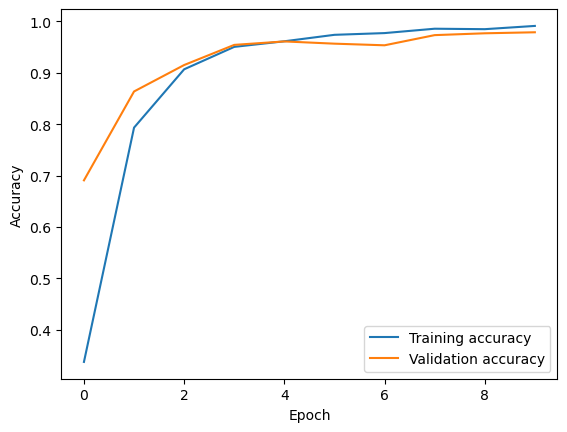

In [25]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


We can see above that overfitting sould not be a concern as the model did quiet well on the validation sets.

6. Create Adversarial Examples Using FGSM

FSGM aims to change the input values of the image very slightly but not enough for it to be detectable by a human.

\begin{align}
\text{FGSM: \  } \  x = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
\end{align}

It takes the original image x, and adds to it a small value epsillon, multiplied by the sign of the gradient of the loss function.

In [33]:
# This function returns the sign of our gradient of the loss function for a given image.
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

np.random.seed(0)

random_indices = tf.constant(np.random.choice(test_images.shape[0], 1000, replace=False))

test_subset = tf.gather(test_images, random_indices)
test_labels_subset = tf.gather(test_labels, random_indices)

# Create adversarial images
epsilon = 0.025
perturbations = create_adversarial_pattern(test_subset, test_labels_subset, model)
adversarial_test_images = test_subset + perturbations * epsilon


7. Evaluate Model Performance on Original and Adversarial Images

We now have the model test our images after FGSM was applied to them.

32/32 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9930
Original Model Accuracy: 99.30%
32/32 [==============================] - 0s 3ms/step - loss: 8.4709 - accuracy: 0.2840
Adversarial Model Accuracy: 28.40%


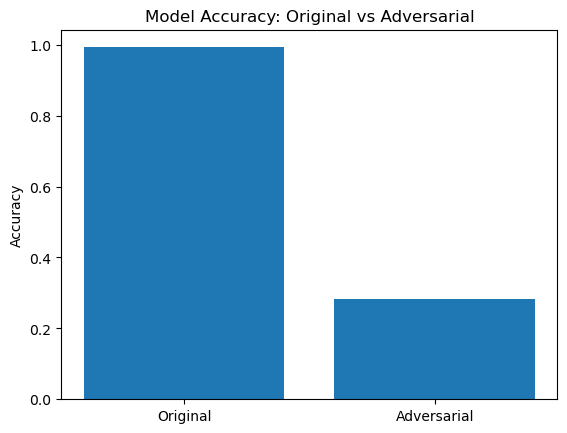

In [34]:
# Original test subset
loss, accuracy_before = model.evaluate(test_subset, test_labels_subset)
print("Original Model Accuracy: {:.2f}%".format(accuracy_before * 100))

# Adversarial test subset
loss, adversarial_accuracy_before = model.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarial Model Accuracy: {:.2f}%".format(adversarial_accuracy_before * 100))

# Plotting comparison
plt.bar(['Original', 'Adversarial'], [accuracy_before, adversarial_accuracy_before])
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Original vs Adversarial')
plt.show()


8. Visualize Some Original and Adversarial Images

Looking at the images below, the images look the same except for some noise added to them.

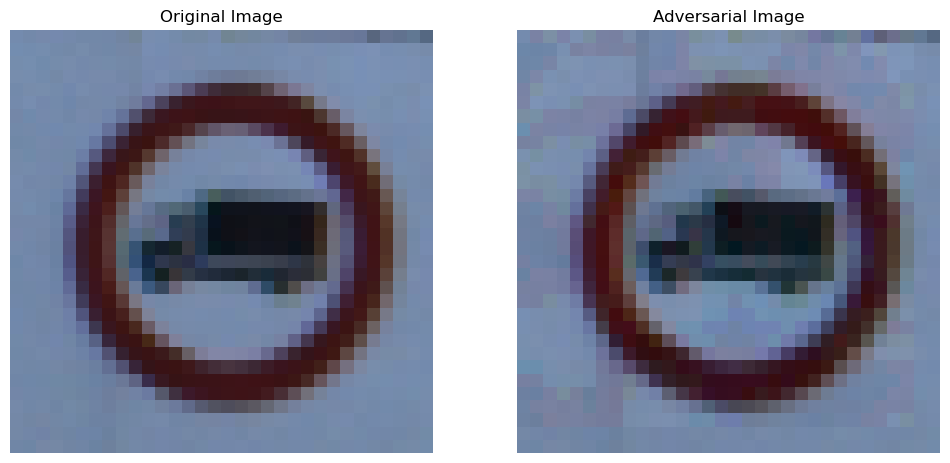

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


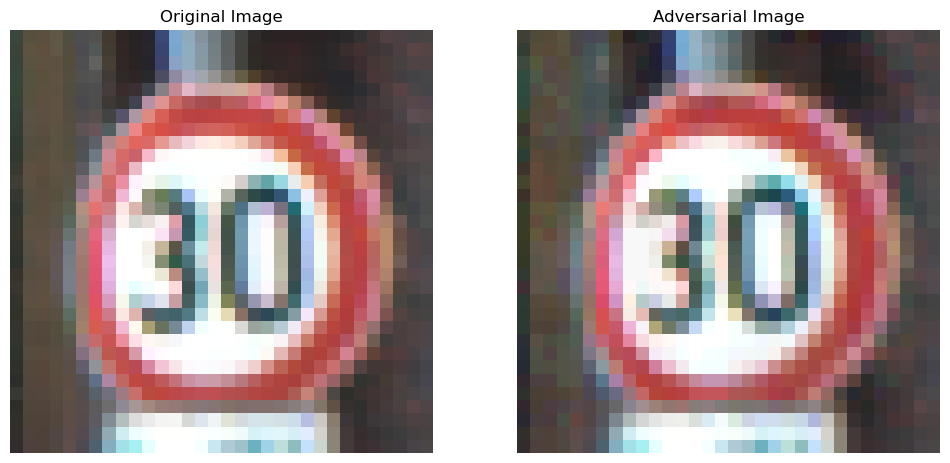

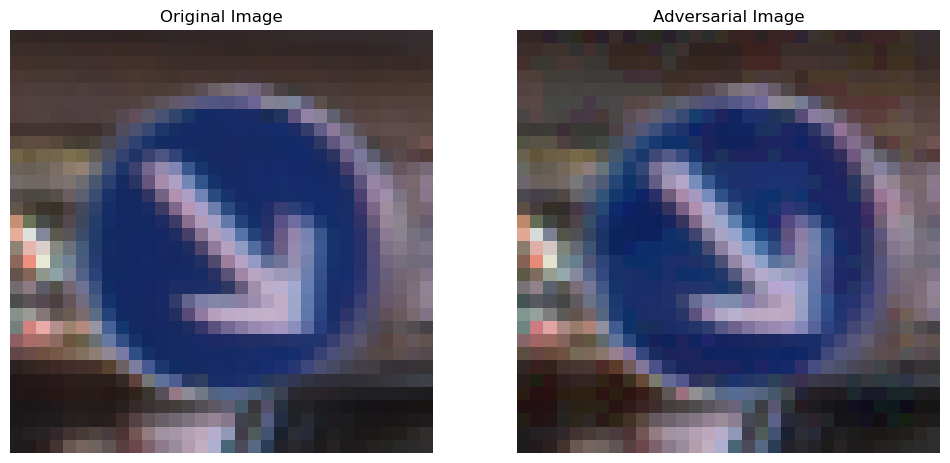

In [14]:
def display_image_pair(original_image, adversarial_image, title1, title2):
    plt.figure(figsize=(12, 6))
    
    # Display original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(original_image[0])
    plt.title(title1)
    plt.axis('off')  # Hide the axis

    # Display adversarial image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(adversarial_image[0])
    plt.title(title2)
    plt.axis('off')  # Hide the axis

    plt.show()

# Loop to display each pair of images
for i in range(3):
    display_image_pair(test_subset[i:i+1], adversarial_test_images[i:i+1], "Original Image", "Adversarial Image")

**DEFENSE**

1. Generate Adversarial Training Set

In [35]:
# Convert inputs to tensors
train_subset_tensor = tf.convert_to_tensor(train_subset, dtype=tf.float32)
train_labels_subset_tensor = tf.convert_to_tensor(train_labels_subset, dtype=tf.int64)

# Train with a slightly higher epsilon for more intense but not entirely different perturbations
epsilon = 0.05

# Use the same function that was used before to generate new adversarial data to train the model on
train_perturbations = create_adversarial_pattern(train_subset_tensor, train_labels_subset_tensor, model)
adversarial_train_images = train_subset_tensor + train_perturbations * epsilon



NameError: name 'train_subset' is not defined

2. Retrain the Model with the Adversarial Training Set

Note that in this step it is important to retrain the model with both the original(unaltered) and the new perturbed images.

Epoch 1/10
347/347 [==============================] - 3s 8ms/step - loss: 3.1602e-05 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9937
Epoch 2/10
347/347 [==============================] - 3s 8ms/step - loss: 2.5702e-05 - accuracy: 1.0000 - val_loss: 0.0682 - val_accuracy: 0.9937
Epoch 3/10
347/347 [==============================] - 3s 7ms/step - loss: 2.1220e-05 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9937
Epoch 4/10
347/347 [==============================] - 3s 8ms/step - loss: 1.7834e-05 - accuracy: 1.0000 - val_loss: 0.0699 - val_accuracy: 0.9941
Epoch 5/10
347/347 [==============================] - 2s 7ms/step - loss: 1.4974e-05 - accuracy: 1.0000 - val_loss: 0.0704 - val_accuracy: 0.9941
Epoch 6/10
347/347 [==============================] - 2s 7ms/step - loss: 1.2835e-05 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9941
Epoch 7/10
347/347 [==============================] - 3s 9ms/step - loss: 1.0965e-05 - accuracy: 1.0000 - val_loss: 0.0727 -

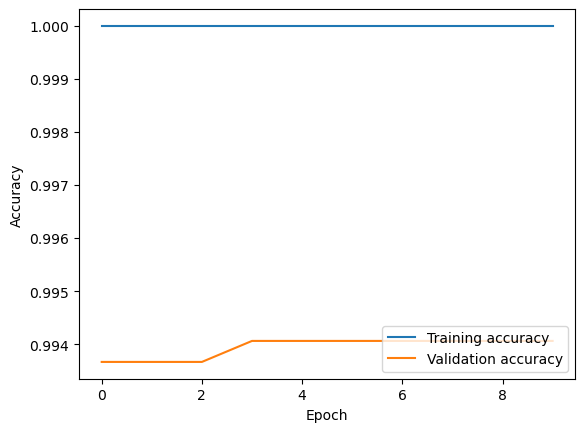

In [ ]:
# Step 1: concatenate the images
combined_train_images = np.concatenate([train_images, adversarial_train_images])

# Step 2: concatenate the labels
combined_train_labels = np.concatenate([train_labels, train_labels_subset])

# Step 3: Use the new concatenated data to retrain the model
history_adversarial = model_adversarial_trained.fit(combined_train_images, combined_train_labels, epochs=10, validation_data=(val_images, val_labels))

# Plot the accuracy against epochs

plt.plot(history_adversarial.history['accuracy'], label='Training accuracy')
plt.plot(history_adversarial.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


3. Evaluate the Model Performance After Adversarial Training

32/32 [==============================] - 0s 4ms/step - loss: 0.0210 - accuracy: 0.9990
Adversarially Trained Model Accuracy on Original Images: 99.90%
32/32 [==============================] - 0s 3ms/step - loss: 0.2074 - accuracy: 0.9730
Adversarially Trained Model Accuracy on Adversarial Images: 97.30%


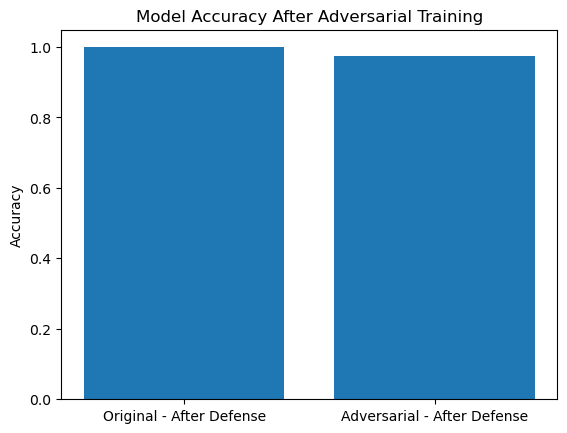

In [ ]:
# Original test subset
loss, accuracy = model_adversarial_trained.evaluate(test_subset, test_labels_subset)
print("Adversarially Trained Model Accuracy on Original Images: {:.2f}%".format(accuracy * 100))

# Adversarial test subset
loss, adversarial_accuracy = model_adversarial_trained.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarially Trained Model Accuracy on Adversarial Images: {:.2f}%".format(adversarial_accuracy * 100))

# Plotting comparison
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy])
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Adversarial Training')
plt.show()


4. Visualize the Effectiveness of the Defense Strategy

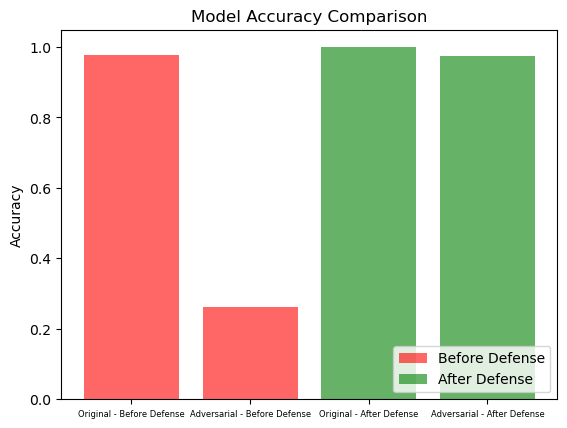

In [ ]:
# Before Adversarial Training
plt.bar(['Original - Before Defense', 'Adversarial - Before Defense'], [accuracy_before, adversarial_accuracy_before], alpha=0.6, color='red')

# After Adversarial Training
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy], alpha=0.6, color='green')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(['Before Defense', 'After Defense'], loc='lower right')
plt.xticks(fontsize=6)
plt.show()
